# <a id='toc1_'></a>[Project: Clustering, Analyzing and Optimizing Drilling Parameters](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Project: Clustering, Analyzing and Optimizing Drilling Parameters](#toc1_)    
  - [Load file and merge header](#toc1_1_)    
  - [Data Wrangle:](#toc1_2_)    
  - [Clustering](#toc1_3_)    
  - [Model Training](#toc1_4_)    
  - [Seeking Mechanical Specific Energy (MSE) min](#toc1_5_)    
  - [Suggest Drilling Parameters of The Drilled Interval](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# !pip install lightgbm
# !pip install catboost
# !pip install xgboost
# !pip install tqdm

from file_handle import load_file_standardize_header
import data_wrangle
import cluster
import ml_models
import optimize_for_mse_min
import optimize_parameters
from utils import get_columns_by_mnemonics

## <a id='toc1_1_'></a>[Load file and merge header](#toc0_)

In [2]:
file_path = r'/home/son/Desktop/development/MSE_analysis/data/wanjing.csv'
df = load_file_standardize_header(file_path)
print("##### Final df after standardization #####")
print(df.head())
print(df.columns)

The first few rows of the original dataset are:
    Depth Interval Drilling_hour Drilling_time   ROP    WOB RPM_Total  \
        m        m             h           min   m/h     KN       rpm   
0  5311.2     0.20           0.1           6.2  1.96   9.93    45.323   
1  5311.4     0.41           0.2           5.6  1.99  14.77   273.065   
2  5311.6     0.60           0.3           5.8  1.99  12.46   273.065   
3  5311.8     0.80           0.4           4.5  2.12   9.90   273.065   
4  5312.0     1.00           0.4           4.0  2.26  13.81   270.065   

  TQ_Table         Si      Shale  Dolomite  Limestone  
      KN.m          %          %         %          %  
0     0.63  51.189020  18.351801  3.693265  24.529388  
1     6.02  51.189020  18.351801  3.693265  24.529388  
2     5.98  51.189020  18.351801  3.693265  24.529388  
3     6.02  51.189020  18.351801  3.693265  24.529388  
4     6.08  53.243932  17.737414  4.039584  22.811830  
##### Final df after standardization #####
   MD

## <a id='toc1_2_'></a>[Data Wrangle:](#toc0_)
Clean df from NAN or negative values in the targetted columns, remove outliers

In [3]:
mnemonics_to_clean = ['DOC', 'BIT_RPM', 'ROP', 'TORQUE', 'WOB', 'Si', 'Dolomite', 'Limestone', 'Shale', 'MSE']
df = data_wrangle.clean_df_by_mnemonics(df, mnemonics_to_clean)
df = data_wrangle.add_columns(df)
df.head()

,MD (m),Interval__unidentified (m),Drilling_hour__unidentified (h),Drilling_time__unidentified (min),ROP (m/h),WOB (klbs),BIT_RPM (rpm),TORQUE (kLbf.ft),Si (%),Shale (%),Dolomite (%),Limestone (%),BIT_DIAMETER (in),DOC (in/rev),Mu,MSE (ksi)
0,5311.2,0.20,0.1,6.2,1.96,0.002234,45.323,0.464664,51.189020,18.351801,3.693265,24.529388,8.5,0.028376,880.827553,71.397531
1,5311.4,0.41,0.2,5.6,1.99,0.003323,273.065,4.440123,51.189020,18.351801,3.693265,24.529388,8.5,0.004782,5658.685877,4047.747585
2,5311.6,0.60,0.3,5.8,1.99,0.002804,273.065,4.410621,51.189020,18.351801,3.693265,24.529388,8.5,0.004782,6663.198202,4020.849391
3,5311.8,0.80,0.4,4.5,2.12,0.002227,273.065,4.440123,51.189020,18.351801,3.693265,24.529388,8.5,0.005094,8442.302061,3799.531520
4,5312.0,1.00,0.4,4.0,2.26,0.003107,270.065,4.484377,53.243932,17.737414,4.039584,22.811830,8.5,0.005491,6112.367965,3560.143820


In [4]:
# mnemonics_to_remove_outliers = ['DOC', 'TORQUE']
# df = data_wrangle.remove_outliers_by_mnemonics(
#     df, mnemonics_to_remove_outliers)

## <a id='toc1_3_'></a>[Clustering](#toc0_)
- Sihouette scores of 3 or 4 clusters are very similar
- Cluster 2 does not have many data points (Check the result below)

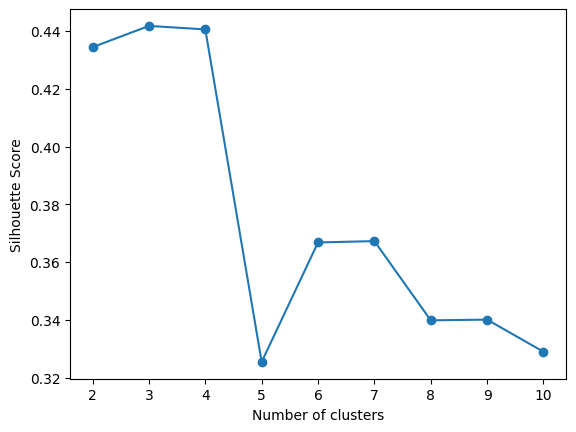

/home/son/miniconda3/envs/deep_learning/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [5]:
columns_for_clustering = ['DOC', 'TORQUE', 'WOB', 'Si', 'Dolomite', 'Limestone', 'Shale','MSE']
df = cluster.perform_kmeans(df, columns_for_clustering)

In [6]:
df['cluster'].value_counts()

cluster
1    565
0    274
2      9
Name: count, dtype: int64

In [7]:
from utils import get_columns_by_mnemonics
# Statistical analysis of DOC and MSE of each cluster
df.groupby('cluster')[get_columns_by_mnemonics(df, 'DOC')].describe()

DOC (in/rev)                                                    \
               count      mean       std       min       25%       50%   
cluster                                                                  
0              274.0  0.006638  0.003121  0.005734  0.006177  0.006392   
1              565.0  0.005601  0.000236  0.005256  0.005434  0.005522   
2                9.0  0.007916  0.007682  0.004782  0.005094  0.005581   

                             
              75%       max  
cluster                      
0        0.006603  0.057488  
1        0.005755  0.006093  
2        0.005728  0.028376

In [8]:
df.groupby('cluster')[get_columns_by_mnemonics(df, 'MSE')].describe()

MSE (ksi)                                                      \
            count         mean          std          min          25%   
cluster                                                                 
0           274.0  3250.619940   414.572932    38.040043  3090.722317   
1           565.0  5065.446789   246.609434  3638.774655  4916.455034   
2             9.0  3295.051376  1227.274725    71.397531  3519.627584   

                                                
                 50%          75%          max  
cluster                                         
0        3305.224464  3437.943639  4548.999790  
1        5088.890823  5231.082727  5598.175036  
2        3560.143820  3799.531520  4047.747585

## <a id='toc1_4_'></a>[Model Training](#toc0_)
- Scaler and best model for each cluster are achieved after this step

In [9]:
# CAUTION: cluster 2 only have 9 samples, which is too small to be used for training.
# We should remove cluster 2 from the training set. However, we still keep it, but needs to be
# aware of the small sample size issue impacting the training result of that cluster 2 significantly.
# As it is low ROP drilling, higher resolution of depth should be used to capture the trend. Or time-based
# analysis with reasonable resolution capturing drilling performance should be used.
import ml_models

X_mnemonics = ['TORQUE', 'WOB', 'RPM' , 'Mu', 'Si', 'Dolomite', 'Limestone', 'Shale']
y_mnemonic = 'ROP'

scalers_best_models = ml_models.perform_optimization(df, X_mnemonics, y_mnemonic)

##### X_mnemonics #####
['TORQUE', 'WOB', 'RPM', 'Mu', 'Si', 'Dolomite', 'Limestone', 'Shale']
##### X_cols #####
['TORQUE (kLbf.ft)', 'WOB (klbs)', 'BIT_RPM (rpm)', 'Mu', 'Si (%)', 'Dolomite (%)', 'Limestone (%)', 'Shale (%)']
Evaluating cluster 2
 ####### X shape is: 8 #########
 ####### X columns are: Index(['TORQUE (kLbf.ft)', 'WOB (klbs)', 'BIT_RPM (rpm)', 'Mu', 'Si (%)',
       'Dolomite (%)', 'Limestone (%)', 'Shale (%)'],
      dtype='object') #########
Cross-validation MSE scores for rf: [0.00268057 0.0009474  0.00833569 0.01697809 0.00430336 0.01705636
 0.00080656]
Average MSE for rf: 0.007301147142857094

Cross-validation MSE scores for xgb: [8.97786826e-04 1.85337556e-03 1.69374322e-02 2.54115602e-02
 7.25406580e-02 1.68841011e-02 9.76434063e-05]
Average MSE for xgb: 0.01923179390240121

Cross-validation MSE scores for svr: [0.01358548 0.00287023 0.01166206 0.04708573 0.0012958  0.00029883
 0.00011779]
Average MSE for svr: 0.010987988620346941

Cross-validation MSE scores f

The MSE above is Mean Squared Error, not Mechanical Specifica Energy

## <a id='toc1_5_'></a>[Seeking Mechanical Specific Energy (MSE) min](#toc0_)

In [11]:
clusters = optimize_for_mse_min.execute_monte_carlo_optimization(
    df_with_clusters=df, scalers_best_models=scalers_best_models, X_mnemonics=X_mnemonics, iterations=100)

df = optimize_for_mse_min.add_mse_min_to_original_data(df, clusters)

#### Seeking MSE min for cluster 2 #####


100%|██████████| 100/100 [00:09<00:00, 10.40it/s]


Cluster: 2
Parameter Ranges for Low MSE:
TORQUE: 0.46 to 0.46
WOB: 0.00 to 0.00
RPM: 45.32 to 45.32
Mu: 247661.40 to 724176.46
Si: 53.00 to 53.24
Dolomite: 3.77 to 4.04
Limestone: 24.28 to 24.53
Shale: 18.00 to 18.35
Corresponding MSE Range: 17.27 to 17.36

#### Seeking MSE min for cluster 0 #####


100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


Cluster: 0
Parameter Ranges for Low MSE:
TORQUE: 0.50 to 0.50
WOB: 0.00 to 0.00
RPM: 27.74 to 27.74
Mu: 120099.91 to 760819.32
Si: 60.56 to 68.61
Dolomite: 0.09 to 0.28
Limestone: 7.26 to 12.29
Shale: 18.95 to 32.04
Corresponding MSE Range: 11.73 to 11.78

#### Seeking MSE min for cluster 1 #####


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]

Cluster: 1
Parameter Ranges for Low MSE:
TORQUE: 4.95 to 4.95
WOB: 0.00 to 0.00
RPM: 262.78 to 262.78
Mu: 74608.22 to 1004863.71
Si: 62.34 to 68.81
Dolomite: 0.09 to 0.19
Limestone: 4.75 to 11.92
Shale: 20.92 to 29.55
Corresponding MSE Range: 1081.93 to 1082.64



In [12]:
# Create output folder if not exists, then export df to csv
import os
output_folder = '../output'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
df.to_csv(os.path.join(output_folder, 'wanjing_with_mse_min.csv'), index=False)

In [13]:
# Summarize mse min for each cluster
df.groupby('cluster')['MSE_min (ksi)'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,274.0,11.730472,0.0,11.730472,11.730472,11.730472,11.730472,11.730472
1,565.0,1081.931107,0.0,1081.931107,1081.931107,1081.931107,1081.931107,1081.931107
2,9.0,17.272547,0.0,17.272547,17.272547,17.272547,17.272547,17.272547


In [14]:
df.head()

,MD (m),Interval__unidentified (m),Drilling_hour__unidentified (h),Drilling_time__unidentified (min),ROP (m/h),WOB (klbs),BIT_RPM (rpm),TORQUE (kLbf.ft),Si (%),Shale (%),Dolomite (%),Limestone (%),BIT_DIAMETER (in),DOC (in/rev),Mu,MSE (ksi),cluster,MSE_min (ksi)
0,5311.2,0.20,0.1,6.2,1.96,0.002234,45.323,0.464664,51.189020,18.351801,3.693265,24.529388,8.5,0.028376,880.827553,71.397531,2,17.272547
1,5311.4,0.41,0.2,5.6,1.99,0.003323,273.065,4.440123,51.189020,18.351801,3.693265,24.529388,8.5,0.004782,5658.685877,4047.747585,2,17.272547
2,5311.6,0.60,0.3,5.8,1.99,0.002804,273.065,4.410621,51.189020,18.351801,3.693265,24.529388,8.5,0.004782,6663.198202,4020.849391,2,17.272547
3,5311.8,0.80,0.4,4.5,2.12,0.002227,273.065,4.440123,51.189020,18.351801,3.693265,24.529388,8.5,0.005094,8442.302061,3799.531520,2,17.272547
4,5312.0,1.00,0.4,4.0,2.26,0.003107,270.065,4.484377,53.243932,17.737414,4.039584,22.811830,8.5,0.005491,6112.367965,3560.143820,2,17.272547


## <a id='toc1_6_'></a>[Suggest Drilling Parameters of The Drilled Interval](#toc0_)

In [20]:
# bounds dictionary of min and max value of wob, rpm, torque
bounds = {
    'wob': (1, 40), # in klbs
    'rpm': (140, 200), # in rpm
    'torque': (10, 15) # in klb.ft
}

MSE_tolerance = 0.3

iterations = 10000

optimized_parameters = optimize_parameters.monte_carlo_optimization(df,
                                                X_mnemonics, 
                                                scalers_best_models, 
                                                bounds, 
                                                mse_tolerance=MSE_tolerance, 
                                                iterations=iterations)

Cluster 2:   0%|          | 0/10000 [00:00<?, ?it/s]

Cluster 1: 100%|██████████| 10000/10000 [00:28<00:00, 356.42it/s]


In [21]:
optimized_parameters.head()

,TORQUE (kLbf.ft),WOB (klbs),BIT_RPM (rpm),Mu,Si (%),Dolomite (%),Limestone (%),Shale (%),ROP (m/h),MSE (ksi),MSE_min (ksi),cluster
0,11.250560,32.706433,145.241801,1.456882,70.328598,0.411542,5.960729,23.299131,2.367465,1403.362482,1081.931107,1
1,10.495227,30.765015,144.183411,1.444835,57.912418,0.254515,9.746467,32.086600,2.370129,1298.232459,1081.931107,1
2,10.138847,23.138041,156.574056,1.855861,58.302593,0.094661,13.141669,28.461078,2.372744,1358.843083,1081.931107,1
3,10.021998,20.913685,162.575978,2.029585,59.082084,0.324049,10.464142,30.129725,2.368000,1396.963008,1081.931107,1
4,10.071195,6.076995,159.772018,7.019007,62.414780,0.383777,2.981445,34.219997,2.367619,1377.294906,1081.931107,1


In [22]:
# Count the number of rows in optimized_parameters dataframe
optimized_parameters.shape[0]

654

In [23]:
optimized_parameters.to_csv(os.path.join(output_folder, 'wanjing_optimized_parameters.csv'), index=False)

In [17]:
# from tqdm.notebook import tqdm
# import pandas as pd
# import numpy as np
# import math

# from config import config_constants

# from tqdm.notebook import tqdm


# # def sample_and_evaluate(df, X_mnemonics, scaler_best_models, mnemonic_constraints, mse_tolerance, num_samples=1000):
# #     X_mnemonics = [mnemonic.lower() for mnemonic in X_mnemonics]
# #     X_cols = get_columns_by_mnemonics(df, X_mnemonics)

# #     for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing rows"):
# #         cluster = row['cluster']
# #         mse_min = row['MSE_min (ksi)']
# #         mse_max = mse_min * (1 + mse_tolerance / 100)
# #         trained_model = scaler_best_models[cluster]['model']
# #         scaler = scaler_best_models[cluster]['scaler']

# #         sample_count = 0
# #         while sample_count < num_samples:
# #             sampled_params = {}
# #             for mnemonic in X_mnemonics:
# #                 if mnemonic in ['wob', 'rpm', 'torque']:
# #                     sampled_params[mnemonic] = np.random.uniform(*mnemonic_constraints.get(mnemonic, (0, 1)))
# #                 else:
# #                     sampled_params[mnemonic] = row[X_cols[X_mnemonics.index(mnemonic)]]

# #             # Calculate mu based on the formula
# #             sampled_params['mu'] = sampled_params['torque'] / (sampled_params['wob'] * config_constants['bit_diameter'] / 36)

# #             predicted_rop = trained_model.predict(scaler.fit_transform(np.array(list(sampled_params.values())).reshape(1, -1)))[0]

# #             wob_term = sampled_params['wob'] / \
# #                 ((config_constants["bit_diameter"]/2)**2 * math.pi)
# #             torque_term = 480 * sampled_params['torque'] * sampled_params['rpm'] / (
# #                 config_constants['bit_diameter']**2 * predicted_rop * 3.2808)
# #             predicted_mse = wob_term + torque_term

# #             if predicted_mse <= mse_max:
# #                 df.loc[_, 'suggested__WOB'] = sampled_params.get('wob')
# #                 df.loc[_, 'suggested__RPM'] = sampled_params.get('rpm')
# #                 df.loc[_, 'suggested__Torque'] = sampled_params.get('torque')
# #                 df.loc[_, 'suggested__Mu'] = sampled_params.get('mu')
# #                 df.loc[_, 'suggested__ROP'] = predicted_rop
# #                 sample_count += 1

# #     return df

# from scipy.optimize import minimize
# import numpy as np
# import pandas as pd

# # Hypothetical function to get columns based on mnemonics (as used in your original code)


# def get_columns_by_mnemonics(df, mnemonics):
#     # Implementation depends on how your DataFrame is structured
#     return [mnemonic for mnemonic in mnemonics if mnemonic in df.columns]

# # Define the objective function


# def objective_function(params, model, row, X_cols, X_mnemonics, config_constants):
#     # Extract parameters from the dictionary
#     wob = params['wob']
#     rpm = params['rpm']
#     torque = params['torque']
#     mu = torque / (wob * config_constants['bit_diameter'] / 36)

#     # Prepare the input for the model
#     X = row[X_cols].copy()
#     for i, mnemonic in enumerate(X_mnemonics):
#         if mnemonic in ['wob', 'rpm', 'torque']:
#             X[i] = params[mnemonic]

#     # Predict ROP
#     predicted_rop = model.predict([X])[0]

#     # Calculate MSE components
#     wob_term = wob / ((config_constants["bit_diameter"]/2)**2 * np.pi)
#     torque_term = 480 * torque * rpm / \
#         (config_constants['bit_diameter']**2 * predicted_rop * 3.2808)
#     predicted_mse = wob_term + torque_term

#     # Objective is to maximize ROP and minimize MSE
#     return -predicted_rop + predicted_mse

# # Function to perform optimization


# def optimize_parameters(row, model, X_cols, X_mnemonics, config_constants, bounds):
#     print("###### X_cols in optimize_parameters ######")
#     print(X_cols)
#     initial_guess = {
#         mnemonic: row[get_columns_by_mnemonics(X_cols, mnemonic)] for mnemonic in X_mnemonics}
#     result = minimize(objective_function, list(initial_guess.values()), args=(
#         model, row, X_cols, X_mnemonics, config_constants), bounds=bounds)
#     return result.x

# # Main function to apply optimization to each row
# def sample_and_optimize(df, X_mnemonics, scaler_best_models, mnemonic_constraints, config_constants):
#     print("###### df in sample_and_optimize ######")
#     print(df.head())
#     X_mnemonics = [mnemonic.lower() for mnemonic in X_mnemonics]
#     print("###### X_mnemonics in sample_and_optimize ######")
#     print(X_mnemonics)
#     X_cols = get_columns_by_mnemonics(df, X_mnemonics)
#     print("###### X_cols in sample_and_optimize ######")
#     print(X_cols)

#     for _, row in df.iterrows():
#         cluster = row['cluster']
#         trained_model = scaler_best_models[cluster]['model']
#         bounds = [mnemonic_constraints[mnemonic]
#                   for mnemonic in X_mnemonics if mnemonic in ['wob', 'rpm', 'torque']]

#         optimized_params = optimize_parameters(
#             row, trained_model, X_cols, X_mnemonics, config_constants, bounds)
#         df.loc[_, 'optimized_WOB'] = optimized_params[0]
#         df.loc[_, 'optimized_RPM'] = optimized_params[1]
#         df.loc[_, 'optimized_Torque'] = optimized_params[2]

#     return df


# mnemonic_constraints = {
#     'wob': (0.1, 40),  # Bounds for WOB in kLbs
#     'rpm': (150, 200),  # Bounds for RPM
#     'torque': (0.1, 10),  # Bounds for Torque in kFt-Lbs
#     'rop': (0.01, 1000),  # Bounds for ROP in m/h
# }

# print(scalers_best_models)
# # Example usage
# result_df = sample_and_optimize(
#     df, X_mnemonics, scalers_best_models, mnemonic_constraints, config_constants)
# print(result_df.head(10))


In [18]:
# import numpy as np
# from scipy.optimize import minimize
# from sklearn.ensemble import RandomForestRegressor
# import pandas as pd
# from tqdm import tqdm
# import math

# from ml_models import perform_optimization
# from config import config_constants
# from utils import get_columns_by_mnemonics

# def get_X_mnemonic_by_mnemonics(X_mnemonics, mnemonic):
#     for X_mnemonic in X_mnemonics:
#         if mnemonic.lower() in X_mnemonic.lower():
#             return X_mnemonic
#     return None

# # Function to compute MSE
# def compute_mse(wob, rpm, torque, rop):
#     wob_term = wob / ((config_constants["bit_diameter"]/2)**2 * math.pi)
#     torque_term = 480 * torque * rpm / \
#         (config_constants['bit_diameter']**2 * rop * 3.2808)

#     return wob_term + torque_term


# def get_initial_guess_for_cluster(df, cluster, X_mnemonics):
#     # Extract row for the cluster with all mnemonics
#     row = df[df['cluster'] == cluster].iloc[0]
#     initial_guess = [row[get_columns_by_mnemonics(df, mnemonic)[0]] for mnemonic in X_mnemonics]
#     return np.array(initial_guess)


# def optimize_for_cluster(df, scaler, trained_model, cluster, X_mnemonics, bounds, iterations):
#     mse_min = df[df['cluster'] == cluster]['MSE_min (ksi)'].iloc[0]

#     def objective_function(params):
#         wob, rpm, torque = params
#         mu = torque / (wob * config_constants['bit_diameter'] / 36)
#         row = df[df['cluster'] == cluster].iloc[0]
#         params_dict = {mnemonic: row[get_columns_by_mnemonics(df, mnemonic)[0]] for mnemonic in X_mnemonics if mnemonic not in ['wob', 'rpm', 'torque']}
#         params_dict[get_X_mnemonic_by_mnemonics(X_mnemonics,'wob')], params_dict[get_X_mnemonic_by_mnemonics(X_mnemonics,'rpm')], params_dict[get_X_mnemonic_by_mnemonics(X_mnemonics,'torque')], params_dict[get_X_mnemonic_by_mnemonics(X_mnemonics,'mu')] = wob, rpm, torque, mu

#         # Ensure the order of params_dict matches X_mnemonics
#         params_list = [params_dict[mnemonic] for mnemonic in X_mnemonics]

#         # Reshape params_list to a 2D array
#         params_list = np.array(params_list).reshape(1, -1)

#         rop = trained_model.predict(scaler.fit_transform(params_list))[0]
#         mse = compute_mse(wob, rpm, torque, rop)

#         # Balancing ROP maximization and MSE minimization
#         alpha = 0.5  # Adjust alpha to balance ROP and MSE
#         composite_score = mse - alpha * rop / mse_min

#         return composite_score

#     results = []
#     for _ in tqdm(range(iterations)):
#         initial_guess = get_initial_guess_for_cluster(df, cluster, X_mnemonics)
#         bounds_sequence = [bounds[mnemonic]
#                            for mnemonic in ['wob', 'rpm', 'torque']]
#         result = minimize(
#             objective_function, initial_guess[:3], method='L-BFGS-B', bounds=bounds_sequence)
#         results.append((result.x, result.fun))

#     best_result = min(results, key=lambda x: x[1])
#     best_params, best_composite_score = best_result

#     # Recalculate ROP and MSE for the best parameters
#     wob, rpm, torque = best_params
#     params_dict = {mnemonic: df[df['cluster'] ==
#                                 cluster].iloc[0][get_columns_by_mnemonics(df, mnemonic)[0]] for mnemonic in X_mnemonics}
#     params_dict[get_X_mnemonic_by_mnemonics(
#         X_mnemonics, 'wob')], params_dict[get_X_mnemonic_by_mnemonics(X_mnemonics, 'rpm')], params_dict[get_X_mnemonic_by_mnemonics(X_mnemonics, 'torque')] = wob, rpm, torque
#     best_rop = trained_model.predict([list(params_dict.values())])[0]
#     best_mse = compute_mse(wob, rpm, torque, best_rop)

#     return wob, rpm, torque, best_rop, best_mse


# def get_bounds(df, column):
#     return max(0.0001, df[column].min()), df[column].max()

# def execute_monte_carlo_optimization(df_with_clusters, 
#                                      scalers_best_models, 
#                                      X_mnemonics, 
#                                      bounds=None, 
#                                      iterations=10, depth_or_cluster='cluster'):
#     if bounds is None:
#         # Calculate bounds once
#         bounds = {
#             'wob': get_bounds(df_with_clusters, get_columns_by_mnemonics(df_with_clusters, 'wob')[0]),
#             'rpm': get_bounds(df_with_clusters, get_columns_by_mnemonics(df_with_clusters, 'rpm')[0]),
#             'torque': get_bounds(df_with_clusters, get_columns_by_mnemonics(df_with_clusters, 'torque')[0])
#         }
#     if depth_or_cluster == 'depth':
#         for index, row in df_with_clusters.iterrows():
#             cluster = row['cluster']
#             scaler = scalers_best_models[cluster]['scaler']
#             trained_model = scalers_best_models[cluster]['model']

#             wob, rpm, torque, best_rop, best_mse = optimize_for_cluster(
#                 df_with_clusters, scaler, trained_model, cluster, X_mnemonics, bounds, iterations)

#             # Update the DataFrame with the optimized values
#             df_with_clusters.loc[index, 'optimized_wob'] = wob
#             df_with_clusters.loc[index, 'optimized_rpm'] = rpm
#             df_with_clusters.loc[index, 'optimized_torque'] = torque
#             df_with_clusters.loc[index, 'predicted_rop'] = best_rop
#             df_with_clusters.loc[index, 'calculated_mse'] = best_mse

#             # Print a progress message every 100 rows
#             if index % 100 == 0:
#                 print(f"Completed optimization for {index} rows")
#         return df_with_clusters
    
#     elif depth_or_cluster == 'cluster':
#         results = []
#         for cluster in scalers_best_models.keys():
#             scaler = scalers_best_models[cluster]['scaler']
#             trained_model = scalers_best_models[cluster]['model']
#             for _ in range(iterations):
#                 wob = np.random.uniform(bounds['wob'][0], bounds['wob'][1])
#                 rpm = np.random.uniform(bounds['rpm'][0], bounds['rpm'][1])
#                 torque = np.random.uniform(bounds['torque'][0], bounds['torque'][1])
#                 mu = torque / (wob * config_constants['bit_diameter'] / 36)
                
#                 # X_cols = get_columns_by_mnemonics(df_with_clusters, X_mnemonics)
#                 params_dict = {mnemonic: df_with_clusters[df_with_clusters['cluster'] == cluster][get_columns_by_mnemonics(df_with_clusters, mnemonic)[0]].iloc[0] for mnemonic in X_mnemonics}
#                 params_dict[get_X_mnemonic_by_mnemonics(X_mnemonics, 'wob')], params_dict[get_X_mnemonic_by_mnemonics(X_mnemonics, 'rpm')], params_dict[get_X_mnemonic_by_mnemonics(
#                     X_mnemonics, 'torque')], params_dict[get_X_mnemonic_by_mnemonics(X_mnemonics, 'mu')] = wob, rpm, torque, mu
#                 # mean_values = df_with_clusters[df_with_clusters['cluster'] == cluster][X_cols].mean()

#                 # print("###### mean_values in execute_monte_carlo_optimization ######")
#                 # print(mean_values)

#                 params_list = [params_dict[mnemonic] for mnemonic in X_mnemonics]

#                 # si_col = get_columns_by_mnemonics(df_with_clusters, 'si')[0]
#                 # shale_col = get_columns_by_mnemonics(df_with_clusters, 'shale')[0]
#                 # dolomite_col = get_columns_by_mnemonics(df_with_clusters, 'dolomite')[0]
#                 # limestone_col = get_columns_by_mnemonics(df_with_clusters, 'limestone')[0]

#                 total = mean_values[si_col] + mean_values[shale_col] + mean_values[dolomite_col] + mean_values[limestone_col]

#                 mean_values[si_col] /= total
#                 mean_values[shale_col] /= total
#                 mean_values[dolomite_col] /= total
#                 mean_values[limestone_col] /= total

#                 params_dict = {**{'wob': wob, 'rpm': rpm, 'torque': torque}, **mean_values.to_dict()}
#                 params_list = [params_dict[mnemonic] for mnemonic in X_mnemonics]
#                 params_list = np.array(params_list).reshape(1, -1)
#                 predicted_rop = trained_model.predict(scaler.transform(params_list))[0]

#                 mse = compute_mse(wob, rpm, torque, predicted_rop)
#                 mse_min = df_with_clusters[df_with_clusters['cluster'] == cluster]['MSE_min (ksi)'].min()
#                 if mse <= mse_min * 1.1:
#                     results.append({**params_dict, 'predicted_rop': predicted_rop, 'calculated_mse': mse, 'mse_min': mse_min, 'cluster': cluster})

#         return pd.DataFrame(results)

# # def execute_monte_carlo_optimization(df_with_clusters, scalers_best_models, X_mnemonics, iterations):
# #     for cluster in df_with_clusters['cluster'].unique():
# #         print(f"#### Optimization for cluster {cluster} #####")
# #         scaler = scalers_best_models[cluster]['scaler']
# #         trained_model = scalers_best_models[cluster]['model']
# #         bounds = {
# #             'wob': get_bounds(df_with_clusters, get_columns_by_mnemonics(df_with_clusters, 'wob')[0]),
# #             'rpm': get_bounds(df_with_clusters, get_columns_by_mnemonics(df_with_clusters, 'rpm')[0]),
# #             'torque': get_bounds(df_with_clusters, get_columns_by_mnemonics(df_with_clusters, 'torque')[0])
# #         }

# #         wob, rpm, torque, best_rop, best_mse = optimize_for_cluster(
# #             df_with_clusters, scaler, trained_model, cluster, X_mnemonics, bounds, iterations)

# #         # Update the DataFrame with the optimized values
# #         df_with_clusters.loc[df_with_clusters['cluster']
# #                              == cluster, 'optimized_wob'] = wob
# #         df_with_clusters.loc[df_with_clusters['cluster']
# #                              == cluster, 'optimized_rpm'] = rpm
# #         df_with_clusters.loc[df_with_clusters['cluster']
# #                              == cluster, 'optimized_torque'] = torque
# #         df_with_clusters.loc[df_with_clusters['cluster']
# #                              == cluster, 'predicted_rop'] = best_rop
# #         df_with_clusters.loc[df_with_clusters['cluster']
# #                              == cluster, 'calculated_mse'] = best_mse

# #     return df_with_clusters
# bounds = {
#     'wob': (1, 40), # in klbs
#     'rpm': (140, 200), # in rpm
#     'torque': (10, 15) # in klb.ft
# }
# final_df = execute_monte_carlo_optimization(df_with_clusters=df,
#                                             scalers_best_models=scalers_best_models,
#                                             X_mnemonics=X_mnemonics,
#                                             bounds=bounds,
#                                             iterations=10)